In [1]:
# This piece of code enables display of multiple output from one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Dimension Reduction (Some approaches)

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

We will work through Ames Dataset, it has been cleaned using the strategies mentioned in this [kaggle notebook](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

In [4]:
ames = pd.read_csv("ames_cleaned.csv")
ames.shape
ames.head()
ames.columns

(2930, 116)

,Unnamed: 0,Order,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan
0,0,1,SC20,RL,141.0,31770,2,None,3,Lvl,...,0,528.0,4,1,2.0,2736.0,1656,62,1,0
1,1,2,SC20,RH,80.0,11622,2,None,4,Lvl,...,0,730.0,0,1,1.0,1778.0,896,120,0,0
2,2,3,SC20,RL,81.0,14267,2,None,3,Lvl,...,0,312.0,0,2,1.5,2658.0,1329,36,1,0
3,3,4,SC20,RL,93.0,11160,2,None,4,Lvl,...,0,522.0,2,2,3.5,4220.0,2110,0,0,0
4,4,5,SC60,RL,74.0,13830,2,None,3,Lvl,...,0,482.0,1,1,2.5,2557.0,1629,34,0,0


Index(['Unnamed: 0', 'Order', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       ...
       'SimplPoolScore', 'SimplGarageScore', 'SimplFireplaceScore',
       'SimplKitchenScore', 'TotalBath', 'AllSF', 'AllFlrsSF', 'AllPorchSF',
       'HasMasVnr', 'BoughtOffPlan'],
      dtype='object', length=116)

### Handle Missing Values

In [5]:
ames.isnull().sum()

Unnamed: 0       0
Order            0
MSSubClass       0
MSZoning         0
LotFrontage      0
                ..
AllSF            1
AllFlrsSF        0
AllPorchSF       0
HasMasVnr        0
BoughtOffPlan    0
Length: 116, dtype: int64

In [6]:
start_ = ames.shape[0]
ames = ames.dropna()
end_ = ames.shape[0]
print("Number of rows removed with missing values : " + str(start_-end_))

Number of rows removed with missing values : 161


### Split Data into Train and Test

In [7]:
train = ames[np.array(ames['YrSold'].astype(np.float32)) < 2010]
test = ames[np.array(ames['YrSold'].astype(np.float32)) >= 2010]
print("train : " + str(train.shape))
print("test : " + str(test.shape))



train : (2451, 116)
test : (318, 116)


In [8]:
X_train = train.copy()
del X_train['SalePrice']
y_train = train.SalePrice.values

X_test = test.copy()
del X_test['SalePrice']
y_test = test.SalePrice.values

### Feature Importance

In [10]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000000
OverallQual         0.798920
AllSF               0.788453
AllFlrsSF           0.715225
GrLivArea           0.710335
                      ...   
KitchenAbvGr       -0.103593
SimplOverallCond   -0.105156
EnclosedPorch      -0.115390
OverallCond        -0.133448
LotShape           -0.276728
Name: SalePrice, Length: 90, dtype: float64


### Split into Numeric and Categorical Features

In [11]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 89
Categorical features : 26


### Feature Importance using Mutual Information

In [12]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(train_num, y_train)
X_train_fs = fs.transform(train_num)
mi = pd.DataFrame([train_num.columns, fs.scores_]).T
mi = mi.rename(columns={0: 'Feature', 1: 'MI Score'})
#mi.sort_values(by='MI Score', ascending=False)
pd.set_option('display.max_rows', None)
print(mi.sort_values(by='MI Score', ascending=False))

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7fd0bb8a3c10>)

                Feature  MI Score
84                AllSF   0.67716
8           OverallQual  0.607252
85            AllFlrsSF  0.497185
28            GrLivArea  0.493957
70         OverallGrade  0.455543
10            YearBuilt  0.405459
42           GarageArea  0.392839
75          GarageScore  0.387817
80     SimplGarageScore  0.384357
15             BsmtQual  0.381244
23          TotalBsmtSF  0.380759
83            TotalBath  0.379734
25             1stFlrSF  0.370373
41           GarageCars  0.358845
55     SimplOverallQual  0.352339
13            ExterQual  0.321924
73         KitchenScore  0.320517
35          KitchenQual  0.316381
40          GarageYrBlt  0.312116
0            Unnamed: 0  0.308813
1                 Order  0.308806
11        YearRemod/Add   0.28561
67        SimplBsmtQual  0.284078
69       SimplExterQual  0.272302
31             FullBath  0.270613
62     SimplKitchenQual  0.257825
72           ExterGrade  0.257002
2           LotFrontage  0.239105
39          Fi

### Vector Quantization using KMeans

In [13]:
from sklearn.cluster import KMeans
subset = train[["AllSF", "AllFlrsSF", "GrLivArea","TotalBsmtSF","1stFlrSF"]]
kmeans = KMeans(n_clusters=6)
subset["Cluster"] = kmeans.fit_predict(subset)
subset["Cluster"] = subset["Cluster"].astype("category")
subset.head()

<ipython-input-13-44075a789035>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cluster"] = kmeans.fit_predict(subset)
<ipython-input-13-44075a789035>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Cluster"] = subset["Cluster"].astype("category")


,AllSF,AllFlrsSF,GrLivArea,TotalBsmtSF,1stFlrSF,Cluster
341,1764.0,882,882,882.0,882,1
342,2868.0,1434,1434,1434.0,1434,5
343,4656.0,2704,2704,1952.0,2000,3
344,2553.0,1608,1608,945.0,945,4
345,3291.0,2283,2283,1008.0,1008,0


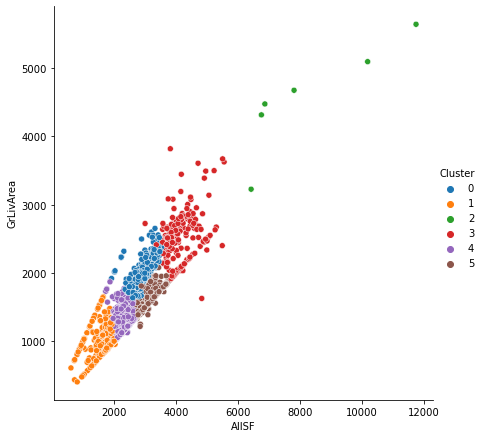

In [14]:
import seaborn as sns
sns.relplot(
    x="AllSF", y="GrLivArea", hue="Cluster", data=subset, height=6,
);

### PCA

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_scaled = StandardScaler().fit_transform(train_num)

pca = PCA()
X_pca = pca.fit_transform(train_scaled)

In [16]:
pca = PCA(0.85)

X_pca = pca.fit_transform(train_scaled)
pca.n_components_

29

#### Plotting the first two PCs

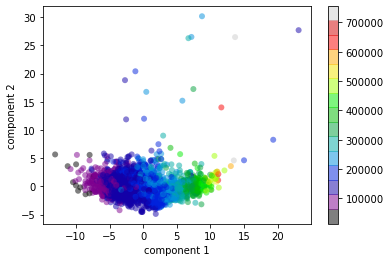

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 15))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Text(0.5, 0, 'number of components')

Text(0, 0.5, 'Proportion of variance explained')

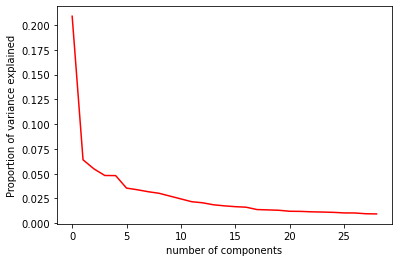

In [18]:
plt.xlabel("number of components")
plt.ylabel("Proportion of variance explained")
plt.plot(pca.explained_variance_ratio_, color ="red")
plt.show()

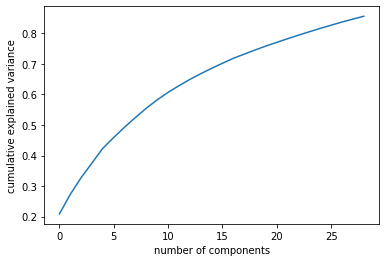

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Nonnegative Matrix Factorization

In [20]:
from sklearn.decomposition import NMF

train_num.shape

model = NMF(n_components=2)
model.fit(train_num)
nmf_features = model.transform(train_num)
print(nmf_features.shape)
print(model.components_.shape)

(2451, 89)

/Users/vinay/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=2)

(2451, 2)
(2, 89)
